# Evaluation the performance of our algorithms

### Load the data

In [1]:
import os
import sys
import pickle
import networkx as nx
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

# Add the project root directory to the system path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from StructuredRag.evaluation import graph_scoring
from StructuredRag.processing import graph_construction

/Users/lukasalemu/Downloads/ls/envs/dissertation_rag/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
# Select the runs you want to load
for experiment in sorted(os.listdir('../results')):
    print('Experiment:', experiment)
    for run in sorted(os.listdir('../results/' + experiment)):
        print("     || Run:", run)

Experiment: v0
     || Run: 2024-05-10
     || Run: 2024-05-14
     || Run: 2024-05-25
     || Run: 2024-05-27
     || Run: 2024-06-14
Experiment: v1
     || Run: 2024-05-10
     || Run: 2024-05-14
Experiment: v3
     || Run: 2024-05-10
     || Run: 2024-05-14
Experiment: v4
     || Run: 2024-05-10
     || Run: 2024-05-14
Experiment: v5
     || Run: 2024-05-14


In [3]:
run_path = 'v0/2024-06-14'

In [4]:
data = {}
# Read the data for the specified experiment
for item in os.listdir('../results/' + run_path):
    print('Loading item:', item.split('.')[0])
    
    with open('../results/' + run_path + '/' + item, 'rb') as f:
        data[item.split('.')[0]] = pickle.load(f)

Loading item: embedded_index
Loading item: edge_thresh
Loading item: adj_matrix


### Evaluate our selected data

In [5]:
# Construct the graph
graph = graph_construction.construct_graph_from_adj_dict(
    adj_dict=data['adj_matrix'],
    edge_thresh=data['edge_thresh'], # -> Needs hyperparameter tuning
    embedded_index=data['embedded_index'],
)
graph_eval = None

graph_scoring.quick_stats(graph)

Adding edges to graph: 100%|██████████| 440/440 [00:00<00:00, 97930.15it/s]


{'number_of_nodes': 441,
 'number_of_edges': 2344,
 'average_degree': 10.630385487528345,
 'density': 0.024159967017109873,
 'clustering_coefficient': 0.20355619362813382}

In [12]:
# write_path = '../results/' + run_path + '/edge_thresh'

# edge_thresh = 29

# with open(write_path, 'wb') as handle:
#     pickle.dump(edge_thresh, handle)

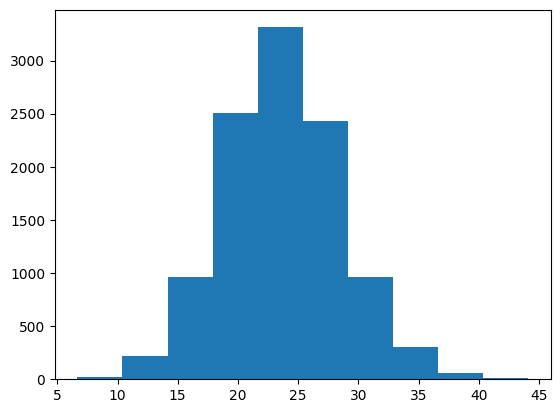

In [6]:
# Plot the distribution of edge_weights:
weights = []

for doc_weight_dict in data['adj_matrix'].values():
    for doc_weight in doc_weight_dict.values():
        weights.append(doc_weight['weight'])

plt.hist(weights)
plt.show()


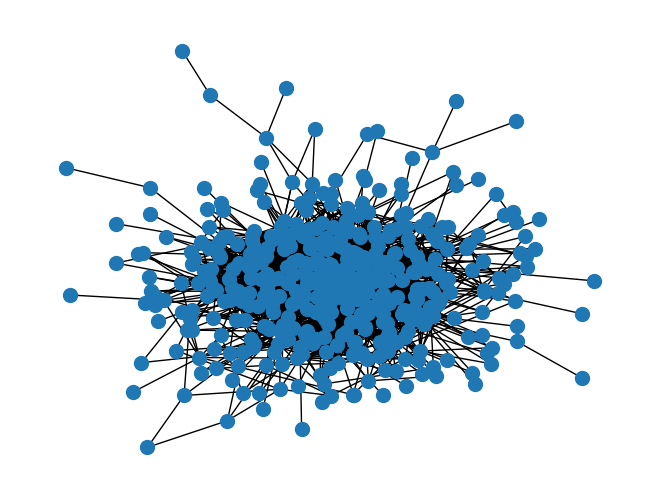

In [7]:
# Visualise the generated graph
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos, node_size=100)

In [7]:
# Evaluate the graph
graph_eval = graph_scoring.evaluate_graph(graph)

# View the results without the communities (as its long)
{k: v for k, v in graph_eval.items() if k != 'communities'}

Calculating simple stats


KeyboardInterrupt: 

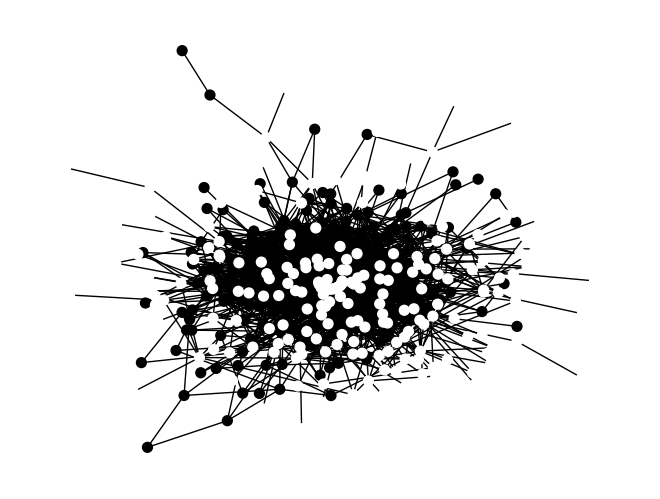

In [8]:
# Draw the graph, but use the node_id to identify which of the two headline document elements is referenced within the node
unique_docs = []
for doc in data['embedded_index']:
    unique_docs.append(doc.metadata['file_name'])
    
unique_docs = set(unique_docs)

# Create a list colors which is the same length as the unique docs
cmap = mpl.colormaps['cubehelix']
list_of_colors = cmap(np.linspace(0, 1, len(unique_docs)))

color_dict = {}
for idx, doc_name in enumerate(unique_docs):
    color_dict[doc_name] = list_of_colors[idx]

colors = []
for n in graph.nodes:
    for doc in data['embedded_index']:
        if doc.id_ == n:
            colors.append(color_dict[doc.metadata['file_name']])
            # if doc.metadata['file_name'] == unique_docs[0]:
            #     colors.append('red')
            # else:
            #     colors.append('blue')
                
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos, node_size=50, node_color=colors)

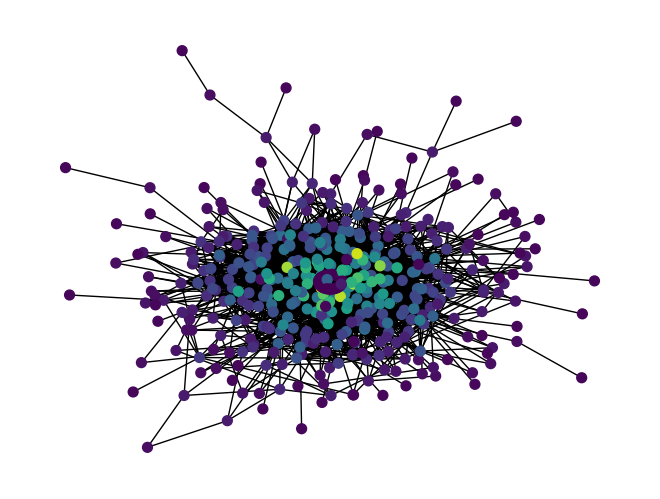

In [9]:
# Step 1: Compute centrality measures
centrality = nx.degree_centrality(graph)

# Color the nodes along a gradient of centrality
color_map = []
for node in graph.nodes:
    color_map.append(centrality[node])
    
# Step 2: Normalize the centrality values
min_centrality = min(color_map)
max_centrality = max(color_map)
color_map = [(centrality - min_centrality) / (max_centrality - min_centrality) for centrality in color_map]

# Step 3: Convert the color map to a list of RGB values using viridis colormap
cmap = mpl.colormaps['viridis']
color_map = [cmap(color) for color in color_map]

# Step 4: Draw the graph with the color map
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos, node_size=50, node_color=color_map)

In [85]:
# if not graph_eval:
graph_eval = {**graph_scoring.community_detection(graph)}

try:
    graph_eval['communities']

    community_node_list = graph_eval['communities']

    # Split viridis into n colors
    cmap = mpl.colormaps['cubehelix']
    colors = cmap(np.linspace(0, 1, len(community_node_list)))

    # Create a dictionary that maps each community to a color
    community_color_dict = {community: color for community, color in zip(community_node_list, colors)}

    node_colors = []

    for node in graph.nodes:
        # Find which community the node belongs to
        for community, color in community_color_dict.items():
            if node in community:
                node_colors.append(color)

    # Draw the graph with the communities colored
    pos = nx.kamada_kawai_layout(graph)
    nx.draw(graph, pos, node_size=50, node_color=node_colors)

    # Print the modularity of the partition
    print("The modularity of this method is:", graph_eval['community_modularity'])

    # # Do some evaluation for each of the communities detected.
    # for com_nodes in community_node_list:
    #     subgraph = graph.subgraph(com_nodes)
    #     subgraph_eval = graph_scoring.simple_stats(subgraph)
    #     # subgraph_eval2 = graph_scoring.attribute_stats(subgraph)
        
    #     pprint.pprint(subgraph_eval)
    #     # pprint.pprint(subgraph_eval2)
        
    #     print("-------------------")
except KeyError:
    print('Skipping')

Calculating community detection
The modularity of this method is: 0.7455540767506401


In [86]:
len(community_node_list)

164

In [74]:
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos, node_size=50, node_color=node_colors)